# 1. Creating adversarial examples with the Fast Gradient Sign Method (FGSM)

This notebook uses Cleverhans to create FGSM adversarial examples for a MNIST CNN. Here we are not targeting a specific class, and instead aim to produce only misclassifications. 

In [57]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from cleverhans.utils_tf import train, model_eval
from cleverhans_tutorials.tutorial_models import ModelBasicCNN
from cleverhans.loss import CrossEntropy
from cleverhans.dataset import MNIST

In [42]:
import tensorflow as tf
tf.__version__

'1.8.0'

In [111]:
NB_EPOCHS = 6
BATCH_SIZE = 128
LEARNING_RATE = .001
NB_FILTERS = 64
NB_CLASSES = 10

## 1a. Load data

In [44]:
train_start = 0
train_end = 60000
test_start = 0
test_end = 10000

mnist = MNIST(train_start=train_start, train_end=train_end,
              test_start=test_start, test_end=test_end)

In [45]:
X_train, Y_train = mnist.get_set('train')
X_test, Y_test = mnist.get_set('test')

In [46]:
X_train.shape

(60000, 28, 28, 1)

In [47]:
type(X_train)

numpy.ndarray

## 1b. Visualize legitimate example

These are the unmodified (i.e. legitimate) training examples. 

In [48]:
def display_mnist_digit(arr):
    """Takes an ndarray with single color channel info and imshows it"""
    plt.imshow(arr.reshape((28, 28)), cmap='gray')
    plt.show()

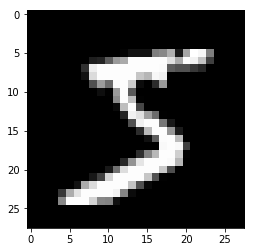

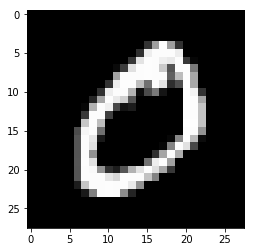

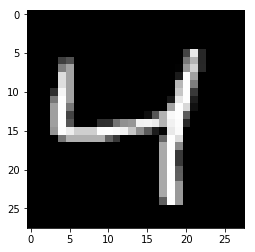

In [49]:
for image_no in range(3):
    display_mnist_digit(X_train[image_no])

## 1c. Train a basic convolutional neural network on only the legitimate examples

### Setup

In [51]:
sess = tf.Session()

In [52]:
model = ModelBasicCNN('basic-cnn', nb_classes=NB_CLASSES, 
                      nb_filters=NB_FILTERS)
loss = CrossEntropy(model, smoothing=0.1)

We need TF placeholders for the input, output, and prediction arrays:

In [53]:
x = tf.placeholder(tf.float32, shape=(None, 28, 28,
                                        1))
y = tf.placeholder(tf.float32, shape=(None, NB_CLASSES))

In [54]:
predictions = model.get_logits(x)

### Train the model

Cleverhans expects a rng seed (for reproducibility): 

In [56]:
rng = np.random.RandomState([666])

train(sess, loss, x, y, X_train, Y_train, 
      args={'nb_epochs': NB_EPOCHS, 
            'batch_size': BATCH_SIZE, 
            'learning_rate': LEARNING_RATE}, 
      rng=rng)

[INFO 2018-10-21 18:38:28,454 cleverhans] Epoch 0 took 27.202895879745483 seconds
[INFO 2018-10-21 18:38:55,846 cleverhans] Epoch 1 took 27.385243892669678 seconds
[INFO 2018-10-21 18:39:23,694 cleverhans] Epoch 2 took 27.84127902984619 seconds
[INFO 2018-10-21 18:39:51,629 cleverhans] Epoch 3 took 27.929041147232056 seconds
[INFO 2018-10-21 18:40:18,812 cleverhans] Epoch 4 took 27.1749849319458 seconds
[INFO 2018-10-21 18:40:45,483 cleverhans] Epoch 5 took 26.664123058319092 seconds
[INFO 2018-10-21 18:40:45,483 cleverhans] Completed model training.


True

### Score the test set

In [59]:
accuracy = model_eval(sess, x, y, predictions, X_test, Y_test,
                      args={'batch_size': BATCH_SIZE})

In [60]:
print(accuracy)

0.9933


This model has >99% accuracy on the test set. 

## 1d. Create adversarial examples

In [63]:
from cleverhans.attacks import FastGradientMethod

In [64]:
fgsm = FastGradientMethod(model, sess=sess)

In [80]:
X_adversarial = fgsm.generate(x, eps=0.3, clip_min=0, clip_max=1)

In [102]:
predictions_adversarial = model.get_logits(X_adversarial)

In [115]:
model_eval(sess, x, y, predictions_adversarial, X_test, Y_test, args={'batch_size': BATCH_SIZE})

0.122

We have significantly reduced the accuracy of this model - down to 12%... we were successful in getting the model to misclassify most of the examples we gave it. 

### 1e. Visualize adversarial examples

In [137]:
is_adversarial_example_correct = tf.equal(tf.argmax(y, axis=-1), tf.argmax(predictions_adversarial, axis=-1))

In [162]:
X_first_batch = np.zeros((BATCH_SIZE,) + X_test.shape[1:],
                 dtype=X_test.dtype)
Y_first_batch = np.zeros((BATCH_SIZE,) + Y_test.shape[1:],
                 dtype=Y_test.dtype)

In [163]:
X_first_batch[:BATCH_SIZE] = X_test[0:BATCH_SIZE]
Y_first_batch[:BATCH_SIZE] = Y_test[0:BATCH_SIZE]

In [164]:
feed_dict = {x: X_cur, y: Y_cur}
is_adversarial_example_correct_ndarr = is_adversarial_example_correct.eval(session=sess, feed_dict=feed_dict)

In [165]:
is_adversarial_example_correct_ndarr

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False]

In [153]:
x_adversarial = X_adversarial.eval(session=sess, feed_dict=feed_dict)

#### before: no adversarial modification


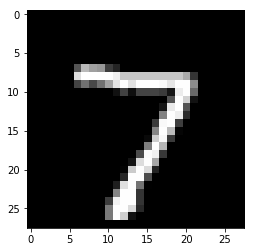

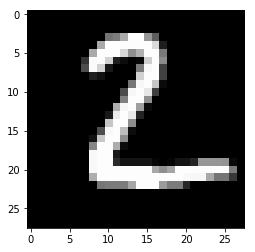

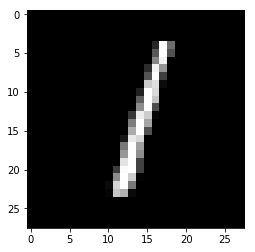

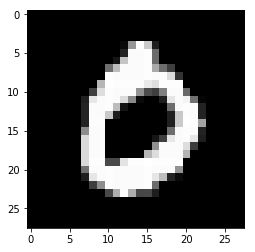

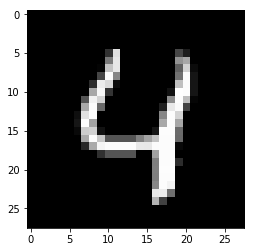

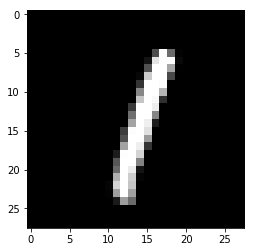

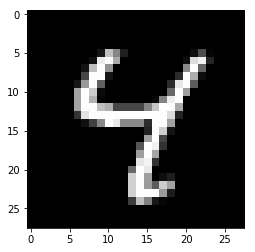

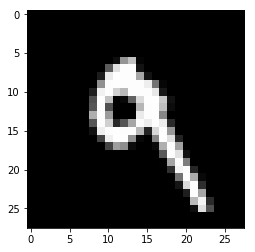

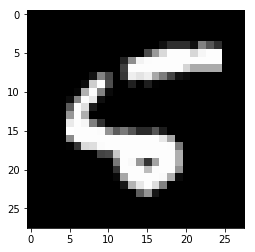

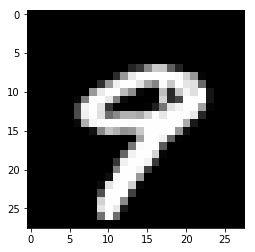

In [157]:
for image_no in range(10):
    if cur_corr_preds[image_no] == False:
        display_mnist_digit(X_cur[image_no])

#### after: adversarial example

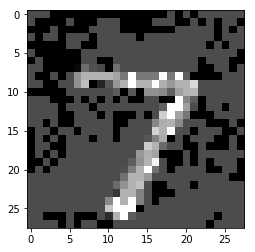

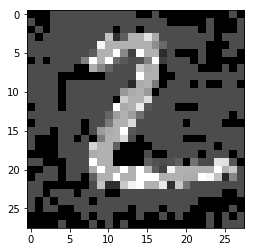

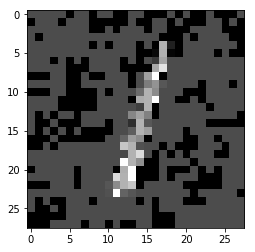

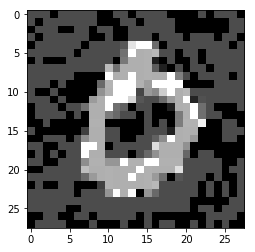

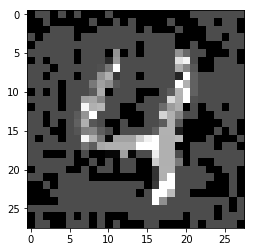

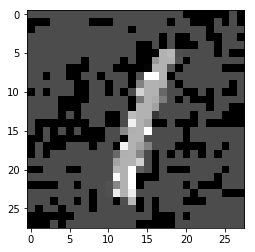

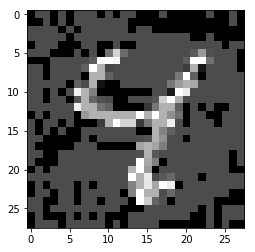

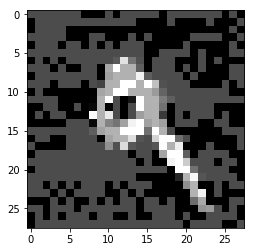

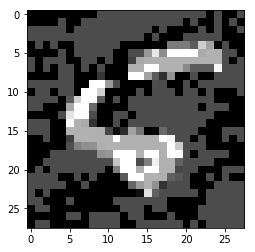

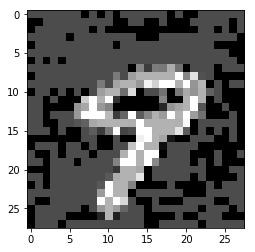

In [156]:
for image_no in range(10):
    if cur_corr_preds[image_no] == False:
        display_mnist_digit(x_adversarial[image_no])

### difference between legitimate and adversarial examples

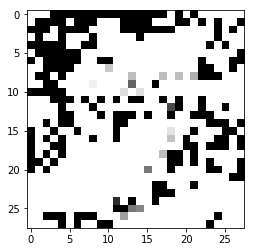

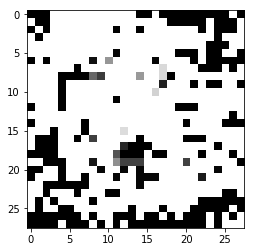

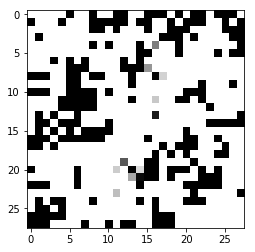

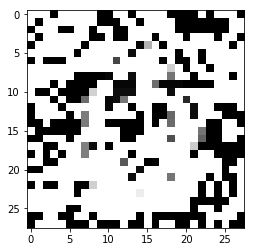

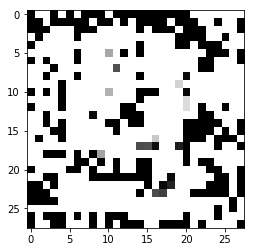

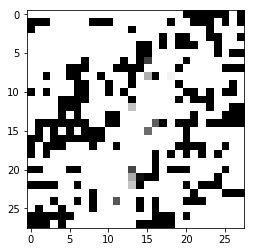

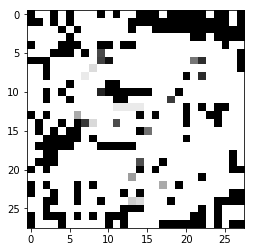

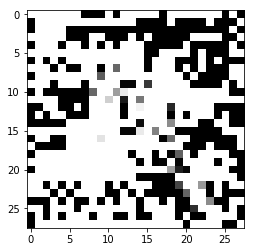

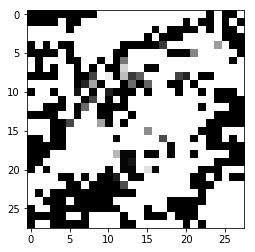

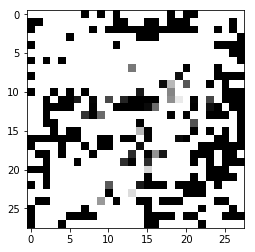

In [166]:
for image_no in range(10):
    if cur_corr_preds[image_no] == False:
        diff = np.abs(X_cur[image_no] - x_adversarial[image_no])
        display_mnist_digit(diff)